# Cardiovascular Disease MLOps Final Project
## Group 4: Prema Mallikarjunan and Outhai Xayavongsa

### Import and Install Libraries

In [41]:
# Install dependencies if needed
!pip install pyathena sqlalchemy pandas matplotlib seaborn fsspec s3fs boto3 shap tqdm --quiet

In [42]:
# Core libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from io import StringIO, BytesIO
from tqdm import tqdm
from IPython.display import display
from sqlalchemy.engine import create_engine
import shap
import matplotlib.patches as mpatches

# Sklearn - preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sklearn - model selection
from sklearn.model_selection import train_test_split

# Sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Sklearn - metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Sklearn - explainability
from sklearn.inspection import permutation_importance

# Suppress warnings
warnings.filterwarnings("ignore")

### Train Initial Model
#### Random Forest or XG Boost

In [43]:
# Load training and validation sets from S3
s3 = boto3.client('s3')
bucket = 'sagemaker-us-east-1-531690656306'

def load_csv_from_s3(key):
    response = s3.get_object(Bucket=bucket, Key=key)
    return pd.read_csv(StringIO(response['Body'].read().decode('utf-8')))
    
train_key = 'cardio_data/cardio_train_split40%_v2.csv'
val_key = 'cardio_data/cardio_val_split10%_v2.csv'

df_train = load_csv_from_s3(train_key)
df_val = load_csv_from_s3(val_key)

In [44]:
# Separate features and target
X_train = df_train.drop(columns=["cardio"])
y_train = df_train["cardio"]
X_val = df_val.drop(columns=["cardio"])
y_val = df_val["cardio"]

# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

### Feature Importance
What features did the model use most often

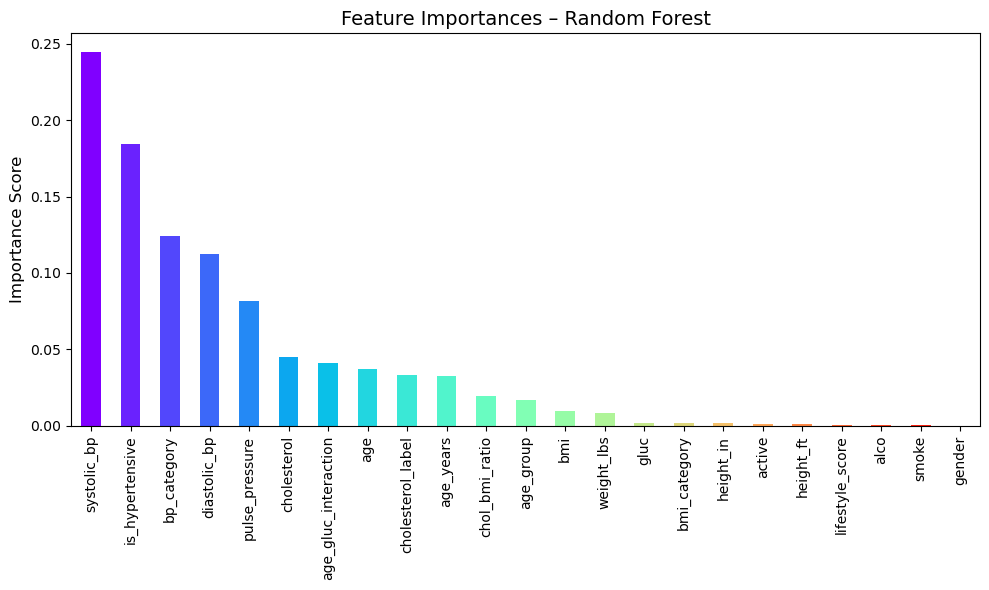

In [45]:
# Feature Importances
feature_names = X_train.columns.tolist()

# Generate feature importances from the trained model
importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Create a color palette with as many colors as features
colors = plt.cm.rainbow(np.linspace(0, 1, len(forest_importances)))

# Plot as a colorful histogram with labels
plt.figure(figsize=(10, 6))
forest_importances.plot(kind='bar', color=colors)
plt.title("Feature Importances – Random Forest", fontsize=14)
plt.ylabel("Importance Score", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The feature importance plot from the Random Forest model highlights which variables contributed most to cardiovascular disease prediction. At the top, BMI and cholesterol-to-BMI ratio are the most influential, suggesting that body composition and its interaction with cholesterol levels are critical predictors. Weight, systolic blood pressure, and height-related features also hold substantial predictive power, pointing to the role of both cardiovascular metrics and body size. Mid-tier features like age, glucose interaction, and pulse pressure reinforce the relevance of metabolic and aging indicators. Meanwhile, lifestyle and categorical features such as smoking, alcohol, and activity level ranked lower, possibly due to lower variance or reporting bias in the dataset. This ranking helps prioritize variables for further analysis and intervention in heart disease risk modeling.

#### Permutation Feature Importance
What features make the model perform better on unseen data

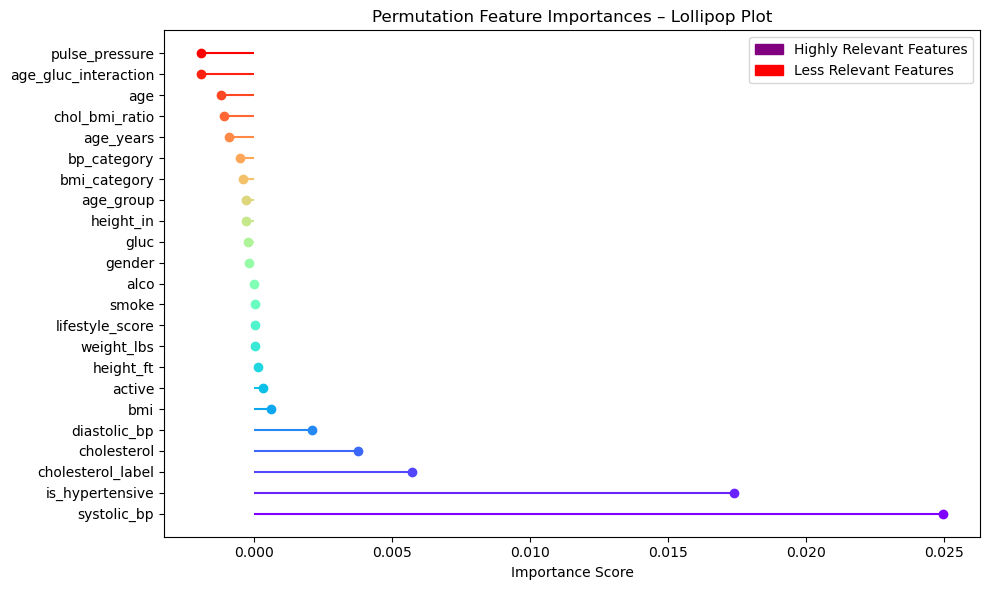

In [46]:
# Generate permutation importances
result = permutation_importance(rf_model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances = pd.Series(result.importances_mean, index=X_val.columns).sort_values(ascending=False)

# Define legend patches
red_patch = mpatches.Patch(color='purple', label='Highly Relevant Features')
green_patch = mpatches.Patch(color='red', label='Less Relevant Features')

# Plot
plt.figure(figsize=(10, 6))
for i, (feature, importance) in enumerate(perm_importances.items()):
    plt.hlines(y=feature, xmin=0, xmax=importance, color=colors[i])
    plt.plot(importance, feature, "o", color=colors[i])

plt.xlabel("Importance Score")
plt.title("Permutation Feature Importances – Lollipop Plot")
plt.legend(handles=[red_patch, green_patch], loc='upper right', frameon=True)
plt.tight_layout()
plt.show()

The Random Forest feature importance plot shows systolic blood pressure, hypertensive status, and blood pressure category as the dominant predictors of cardiovascular disease, contributing the most to tree splits during model training. Lower-ranked features like lifestyle, smoking, and gender had minimal impact, suggesting physiological indicators were stronger predictors than behavioral or demographic variables in this dataset.

In [47]:
!aws s3 cp cardio_random_forest.ipynb s3://sagemaker-us-east-1-531690656306/cardio_project/

upload: ./cardio_random_forest.ipynb to s3://sagemaker-us-east-1-531690656306/cardio_project/cardio_random_forest.ipynb
